See [master/ndvi_animation.ipynb](master/ndvi_animation.ipynb) for an introduciton to this notebook




NDVI At the field level

Where Part 1 calculated the NDVI values for the bounding box area of interest, Part 2 focuses on providing insights 
at the field level. This is achieved by reading in polygons defining fields via the geopandas python library 
and extracting the NDVI values as created in Part 1 for each individual field.

In [53]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import rasterio
from rasterio.plot import show, reshape_as_image
from pyproj import Transformer
from satsearch import Search

%matplotlib inline

# sentinel-2 COG cloud store
url = "https://earth-search.aws.element84.com/v0/"

# cloud cover tolerances
scene_cloud_tolerance = 50 # (Variable) The % of cloud tolerated in the 100x100km Sentinel-2 scene
subset_scene_cloud_tolerance = 2 # (Variable) The % of cloud tolerated in the area of interest 

# Bounding Box delineating the spatial extent for NDVI mapping
bbox =[171.9088514845592, -43.8745987874565, 171.94923031833974, -43.84539377803524]

# The date range for mapping NDVI overtime
date_range = "2018-01-01/2021-12-21"


In [54]:

transform_window = None
def range_request(image_url, bbox):
    """
    Request and read just the required pixels from the COG
    """
    
    with rasterio.open(image_url) as src:
        coord_transformer = Transformer.from_crs("epsg:4326", src.crs)
        # calculate pixels to be streamed from the COG
        coord_upper_left = coord_transformer.transform(bbox[3], bbox[0])
        coord_lower_right = coord_transformer.transform(bbox[1], bbox[2])
        pixel_upper_left = src.index(coord_upper_left[0], coord_upper_left[1])
        pixel_lower_right = src.index(coord_lower_right[0], coord_lower_right[1])
         
                
        # request only the bytes in the window
        window = rasterio.windows.Window.from_slices(
            (pixel_upper_left[0], pixel_lower_right[0]),
            (pixel_upper_left[1], pixel_lower_right[1]),
        )

        # The affine transform - This will allow us to 
        # translate pixels coordiantes back to geospatial coordiantes
        transform_window = rasterio.windows.transform(window,src.transform)
        
        bands = 1
        if "TCI" in image_url: # aka True Colour Image aka RGB
            bands = [1, 2, 3]

        subset = src.read(bands, window=window)
        return(subset, transform_window)

In [55]:

def image_search(bbox, date_range, scene_cloud_tolerance):
    """
    Using SatSearch find all Sentinel-2 images
    that meet our criteria
    """
    
    search = Search(
        bbox=bbox,
        datetime=date_range,
        query={
            "eo:cloud_cover": {"lt": scene_cloud_tolerance}
        },  
        collections=["sentinel-s2-l2a-cogs"],
        url=url,
    )

    return search.items()

In [56]:
def is_cloudy(scl, tolerance):
    """
    Calculate the cloud cover in the subset-scene
    """
    
    image_size = scl.size
    unique, count = np.unique(scl, return_counts=True)
    counts = dict(zip(unique, count))

    # sum cloud types
    cloud_med_probability = counts.get(8, 0)
    cloud_high_probability = counts.get(9, 0)
    thin_cirrus = counts.get(10, 0)
    total_cloud_cover = cloud_med_probability + cloud_high_probability + thin_cirrus  
    
    # percent subscene cloud cover
    percent_cloud_cover = 100 * float(total_cloud_cover) / float(image_size)
    #print(f"\t cloud cover {percent_cloud_cover}%")
    if percent_cloud_cover > tolerance:
        return True
    return False

In [57]:
images= []

items = image_search(bbox, date_range, scene_cloud_tolerance)
for item in items:
    
    # Refs to images
    red = item.asset("red")["href"]
    nir = item.asset("nir")["href"]
    rgb = item.asset("visual")["href"]
    scl = item.asset("SCL")["href"]
    date = item.date.strftime("%d/%m/%Y")
    
    # if subset_scene_cloud_tolerance is set. check for 
    # clouds in sub-scene before continuing 
    if subset_scene_cloud_tolerance:
        #print(f"Assessing Cloud Cover: {date}")
        scl_subset, transform_window = range_request(scl, bbox)
        if is_cloudy(scl_subset, subset_scene_cloud_tolerance):
            #print(f"clouds in subset-scene: {date}")
            continue  

    # Streamed pixels within bbox
    red_subset, transform_window = range_request(red, bbox)
    nir_subset, transform_window = range_request(nir, bbox)
    rgb_subset, transform_window = range_request(rgb, bbox)

    # Calcualte NDVI
    ndvi_subset = (nir_subset.astype(float) - red_subset.astype(float)) / (
        nir_subset + red_subset
    )
    
    # Store the data for further processing
    images.append(
        {"date": date, "rgb": rgb_subset, "ndvi": ndvi_subset,'transform_window': transform_window}
    )

# reverse list as to be oldest to newest
images.reverse()

##### Reading in the fields
For the purpose of this, I defined 6 polygons representing 6 fields I wanted to track the NDVI values across. 
The field extents are read into at geopandas dataframe for plotting. 


In [58]:
import geopandas 

fields = geopandas.read_file('data/canterbury_fields.geojson')

Once read in we can visualise the fields extents.

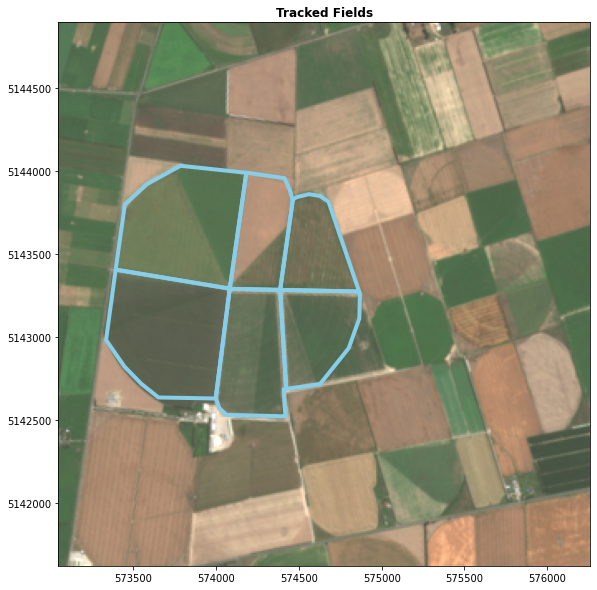

In [59]:
fig, ax = plt.subplots(1, figsize=(10, 10))

rgb_axes = show(images[0]['rgb'], 
                transform=images[0]['transform_window'], 
                ax=ax,
                alpha=.75,
                cmap="RdYlGn", 
                title="Tracked Fields")
fields.boundary.plot(ax=ax, color='skyblue', linewidth=4)
rgb_axes.ticklabel_format(style ='plain') # show full y-coords

##### Masking NDVI by field

By adding a function using numpy array masking, we can create individual field representations of the NDVI 
values by masking all NDVI array values that fall outside of each field.

In [60]:
import numpy.ma as ma
from rasterio import features

def mask_ndvi_by_field(ndvi_image, field_geom):
    """
    returns a numpy mask
    """
    mask = features.geometry_mask(field_geom, 
                                out_shape=( ndvi_image.shape[0],  ndvi_image.shape[1]),
                                transform=image['transform_window'], 
                                all_touched=False, 
                                invert=False)
    ndvi_masked = ma.masked_array(image['ndvi'], mask)
    return ndvi_masked

Using the above function, we iterate over all the NDVI images associated with each date and stored the NDVI 
values within each field against the field_id

In [61]:
for image in images:
    ndvi_fields = {}
    
    for index, row in fields.iterrows():
        field_mask = mask_ndvi_by_field(image['ndvi'],row.geometry)
        ndvi_fields[row.field_id] = field_mask
        image['ndvi_fields'] = ndvi_fields

We can then select one of the NDVI records and visualise just the fields of interest with the associated RGB 
image for context

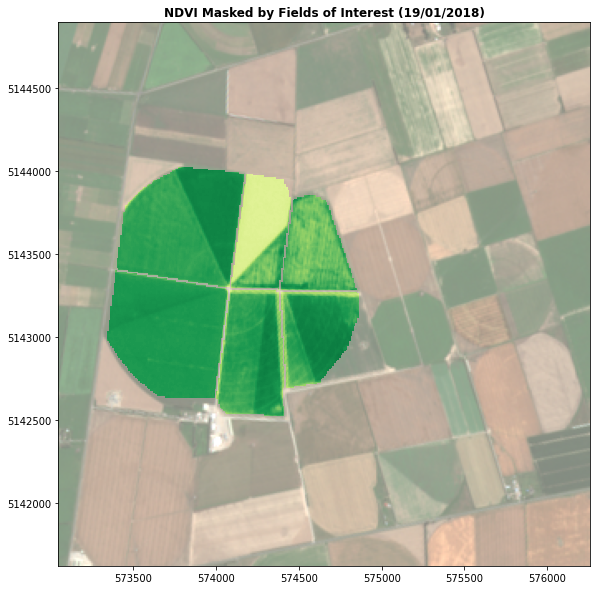

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
show(images[0]['rgb'], transform=image['transform_window'], ax=ax, alpha=.50)
        
for field_id, field_ndvi in images[0]['ndvi_fields'].items():
    rgb_axes= show(field_ndvi, transform=image['transform_window'],
         ax=ax,
         cmap="RdYlGn", 
         vmin=-1, 
         vmax=1, 
         title=f"NDVI Masked by Fields of Interest ({images[0]['date']})")
    
rgb_axes.ticklabel_format(style ='plain') # show full y-coords

Via matplotlibs `gridspec` we can also grid all occurrences of the imagery and NDVI values that met our satsearch
(see Part 1 for filtering via satsearch) query. This provides an interesting insight into the changing NDVI values
and thus agricultural practices over time. 


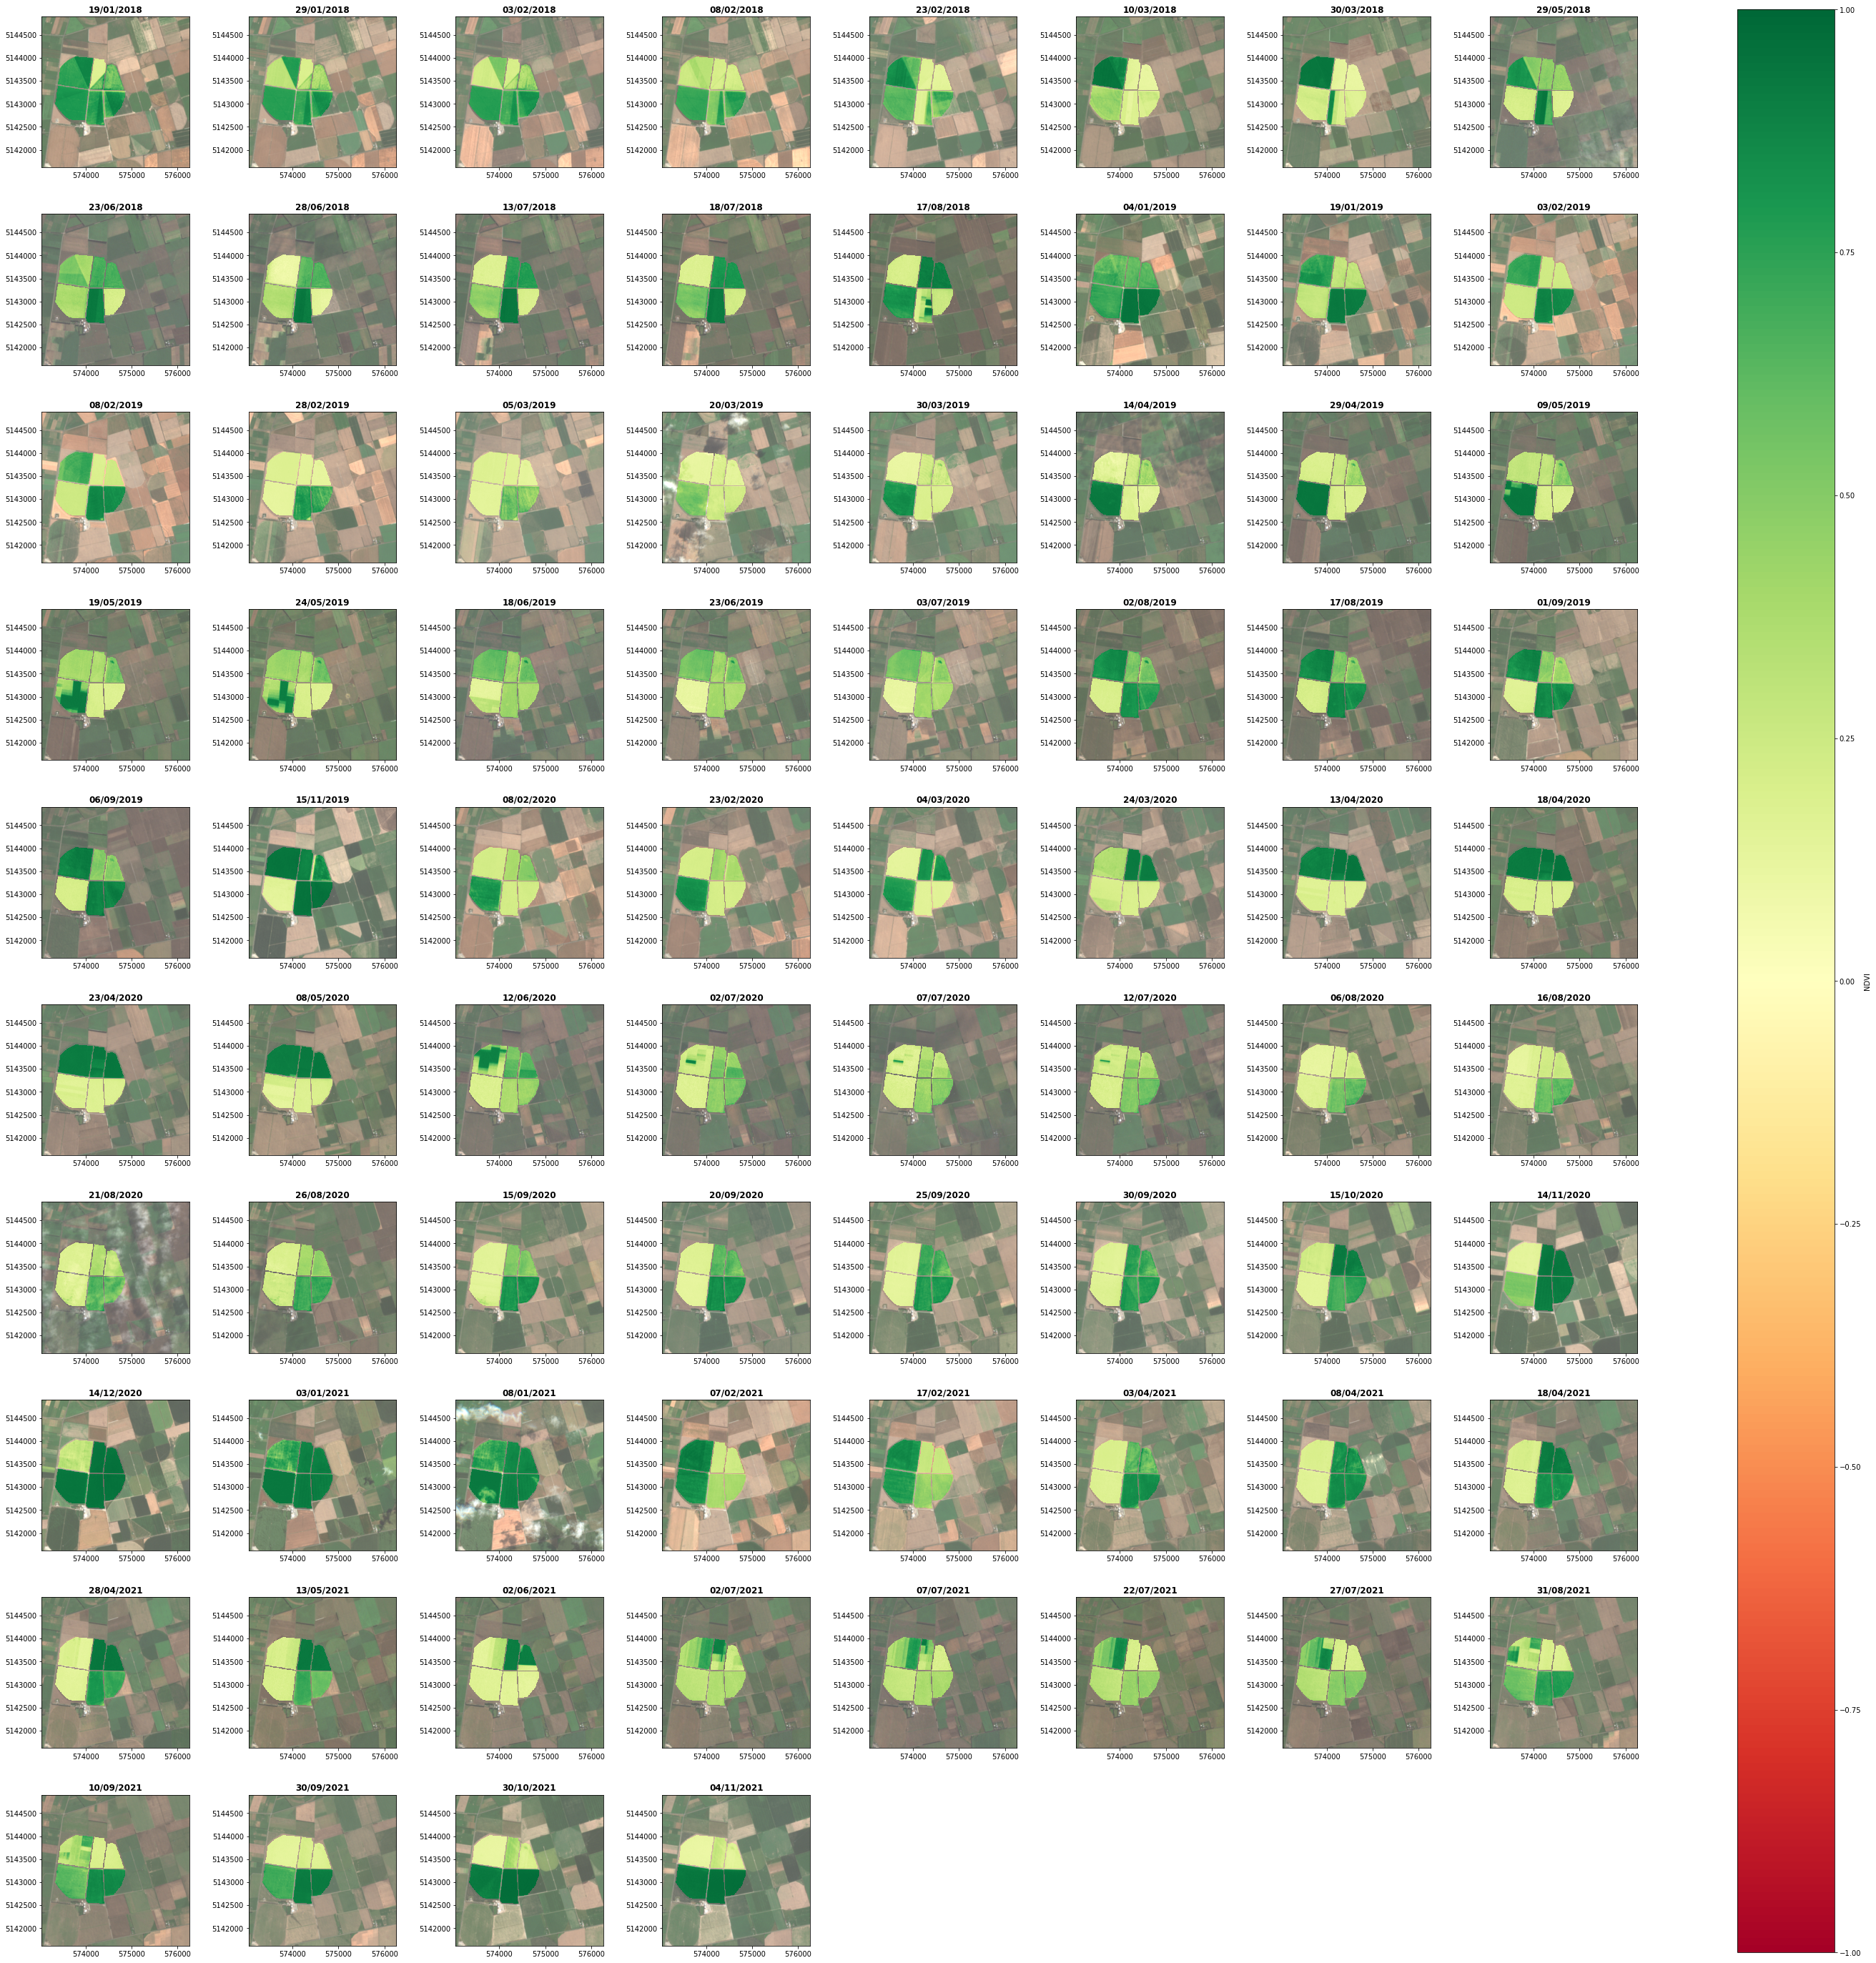

In [67]:
from matplotlib import gridspec
import matplotlib as mpl

# compute the number of rows and columns
n_plots = len(images)
n_cols = int(np.sqrt(n_plots))
n_rows = int(np.ceil(n_plots / n_cols))


# setup the plot
scale = max(n_cols, n_rows)
fig = plt.figure(figsize=(5 * scale, 5 * scale))
grid = gridspec.GridSpec(n_rows, n_cols, fig, wspace=0.4)


# iterate through each subplot and plot each set of data
for i in range(n_plots):
    ax = fig.add_subplot(grid[i])
    axes_subplot = show(images[i]['rgb'],
                        transform=transform_window, 
                        ax=ax,  
                        alpha=.65, 
                        title = images[i]['date'] )
    
    # plot the field data
    for field_id, field_ndvi in images[i]['ndvi_fields'].items():
        im = show(field_ndvi, transform=transform_window,
             ax=ax,
             cmap="RdYlGn", 
             vmin=-1, 
             vmax=1, 
             )
    axes_subplot.ticklabel_format(style ='plain') # show full y-coords

# Add custom color bar
mpl.cm.cool
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="RdYlGn"),
             ax=grid.figure.get_axes() , orientation='vertical', label='NDVI')


##### Graphing NDVI overtime 
Visualising NDVI over time via a map plot provides interesting insights. However, graphing these values over time 
may provide more insight. 

For the purpose of this we are going to track just one of our fields. Field 6. Below we highlight this field.

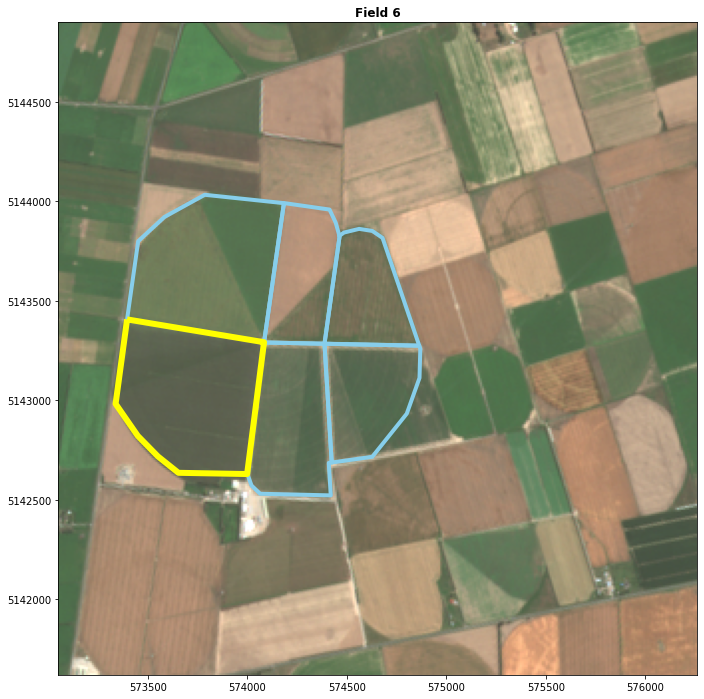

In [64]:
# Use geopandas `loc` to select the field where field_id == 6
field_6 = fields.loc[fields['field_id'] == '6']

fig, ax = plt.subplots(1, figsize=(12,12))
    
rgb_axes = show(images[0]['rgb'], 
                transform=image['transform_window'], 
                ax=ax,
                alpha=.75,
                cmap="RdYlGn", 
                title="Field 6")
fields.boundary.plot(ax=ax, color='skyblue', linewidth=4)
field_6.boundary.plot(ax=ax, color='yellow', linewidth=6)                             
rgb_axes.ticklabel_format(style ='plain') # show full y-coords

Using matplotlib and numpy calculate the mean NDVI value for field 6 for each image date and plot. 


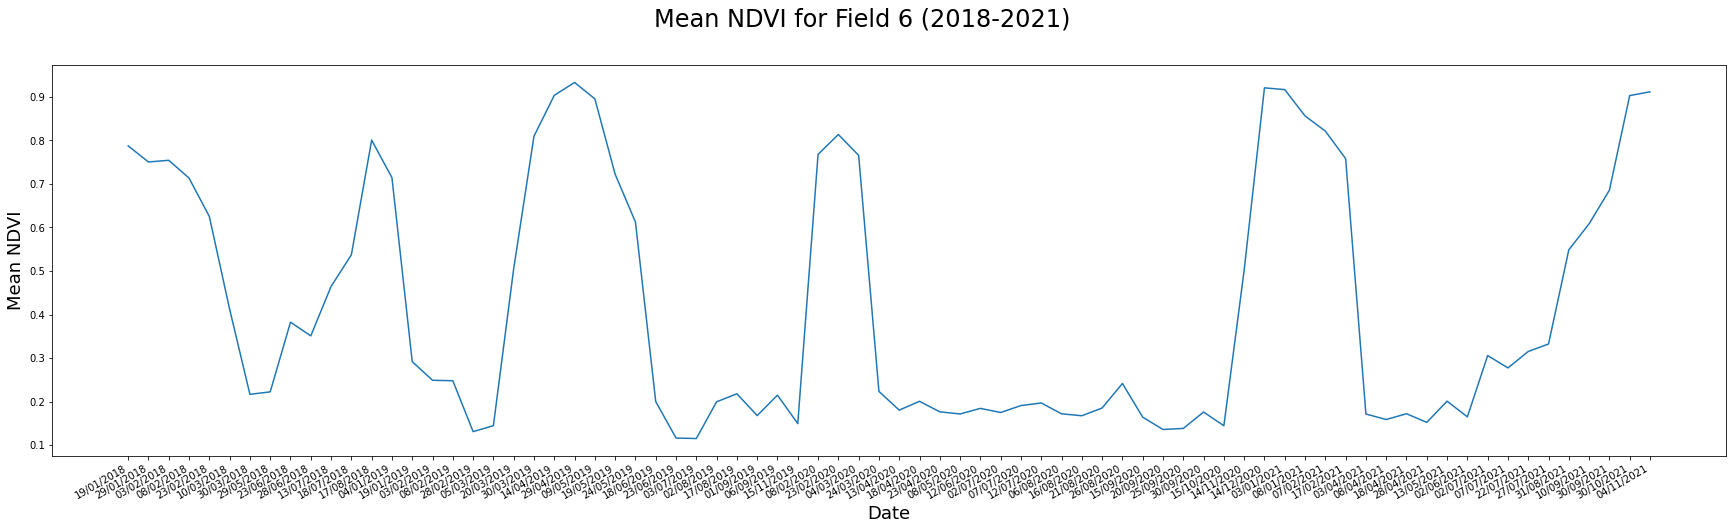

In [70]:
dates = np.array([images[i]['date'] for i in range(len(images))])
ndvi_values = np.array([images[i]['ndvi_fields']["6"].mean() for i in range(len(images))])


fig, ax = plt.subplots(figsize=(30, 8))

ax.plot_date(dates, ndvi_values, marker='', linestyle='-')
fig.autofmt_xdate()
fig.suptitle('Mean NDVI for Field 6 (2018-2021)', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mean NDVI', fontsize=18)

plt.show()

Having plotted the average NDVI for Field 6 it is much clearer when agricultural practices are occurring and 
at what frequency. For example, harvests are evident via the sharp drop offs in NDVI values.   

### Summary
Interesting insights into agricultural practices can be achieved by mapping NDVI over time. In this case the agricultural environment is highly controlled and it would be interesting to map seasonal changes in more natural environments that would show stronger seasonal patterns. 

While this process has been developed for calculating NDVI, other remote sensing indices such as those for indicating water and snow could be applied with very little effort. 
